# Cyclistic Bike-share Analysis

Importing necessary libraries

In [80]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
data_files = ['202004-divvy-tripdata.csv', '202005-divvy-tripdata.csv', '202006-divvy-tripdata.csv', '202007-divvy-tripdata.csv', 
              '202008-divvy-tripdata.csv', '202009-divvy-tripdata.csv', '202010-divvy-tripdata.csv', '202011-divvy-tripdata.csv', 
              '202012-divvy-tripdata.csv', '202101-divvy-tripdata.csv', '202102-divvy-tripdata.csv', '202103-divvy-tripdata.csv']

df_import = pd.concat((pd.read_csv(filename) for filename in data_files), ignore_index=True)

Creating a copy of the dataframe to use it for analysis. If anything goes wrong, we can always use the original df to create another copy.
This is way faster than importing the files again.

In [3]:
df = df_import.copy()
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,A847FADBBC638E45,docked_bike,2020-04-26 17:45:14,2020-04-26 18:12:03,Eckhart Park,86,Lincoln Ave & Diversey Pkwy,152.0,41.8964,-87.6610,41.9322,-87.6586,member
1,5405B80E996FF60D,docked_bike,2020-04-17 17:08:54,2020-04-17 17:17:03,Drake Ave & Fullerton Ave,503,Kosciuszko Park,499.0,41.9244,-87.7154,41.9306,-87.7238,member
2,5DD24A79A4E006F4,docked_bike,2020-04-01 17:54:13,2020-04-01 18:08:36,McClurg Ct & Erie St,142,Indiana Ave & Roosevelt Rd,255.0,41.8945,-87.6179,41.8679,-87.6230,member
3,2A59BBDF5CDBA725,docked_bike,2020-04-07 12:50:19,2020-04-07 13:02:31,California Ave & Division St,216,Wood St & Augusta Blvd,657.0,41.9030,-87.6975,41.8992,-87.6722,member
4,27AD306C119C6158,docked_bike,2020-04-18 10:22:59,2020-04-18 11:15:54,Rush St & Hubbard St,125,Sheridan Rd & Lawrence Ave,323.0,41.8902,-87.6262,41.9695,-87.6547,casual


### Data Cleaning

Deleting columns which are not relevant for analysis

In [5]:
df.drop(columns=['start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 
                 'start_lat', 'start_lng', 'end_lat', 'end_lng'], axis=1, inplace=True)

In [6]:
duplicate_df = df[df.duplicated()]
print(f"There are {duplicate_df.shape[0]} duplicate rows")

There are 0 duplicate rows


Great! There are no duplicate rows in the dataset. Let's delete the `duplicate_df` and carry on with our analysis

In [7]:
del duplicate_df

In [8]:
print(f'The bike-share dataset has {df.shape[0]:,} rows and {df.shape[1]} columns')

The bike-share dataset has 3,489,748 rows and 5 columns


In [9]:
# Checking for missing values

df.isnull().sum()

ride_id          0
rideable_type    0
started_at       0
ended_at         0
member_casual    0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489748 entries, 0 to 3489747
Data columns (total 5 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   ride_id        object
 1   rideable_type  object
 2   started_at     object
 3   ended_at       object
 4   member_casual  object
dtypes: object(5)
memory usage: 133.1+ MB


We can see that `started_at` and `ended_at` have object dtypes. Converting them to `datetime` dtypes will allow us to calculate various datetime related
metrics.

In [11]:
# Creating date columns from started_at and ended_at
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

In [12]:
# Creating a ride length (in minutes) column
df['ride_length'] = (df['ended_at'] - df['started_at']) / pd.Timedelta(minutes=1)
df['ride_length'] = df['ride_length'].astype('int32')

In [14]:
df[df['ride_length'] < 1].count()

ride_id          60316
rideable_type    60316
started_at       60316
ended_at         60316
member_casual    60316
ride_length      60316
dtype: int64

Removing the entries where 
* `ride_length` is negative or zero.
    
    This is done due to the fact that Cyclistic collected some bikes to maintain them, data for these were either marked with negative values or zero.
* `ride_length` less than 1 minute.
    
    Because `ride_length` less than 1 minute is most probably an error by the user.

In [15]:
df = df[df['ride_length'] >= 1].reset_index(drop=True)

In [16]:
df.head()

,ride_id,rideable_type,started_at,ended_at,member_casual,ride_length
0,A847FADBBC638E45,docked_bike,2020-04-26 17:45:14,2020-04-26 18:12:03,member,26
1,5405B80E996FF60D,docked_bike,2020-04-17 17:08:54,2020-04-17 17:17:03,member,8
2,5DD24A79A4E006F4,docked_bike,2020-04-01 17:54:13,2020-04-01 18:08:36,member,14
3,2A59BBDF5CDBA725,docked_bike,2020-04-07 12:50:19,2020-04-07 13:02:31,member,12
4,27AD306C119C6158,docked_bike,2020-04-18 10:22:59,2020-04-18 11:15:54,casual,52


<Axes: xlabel='member_casual', ylabel='ride_length'>

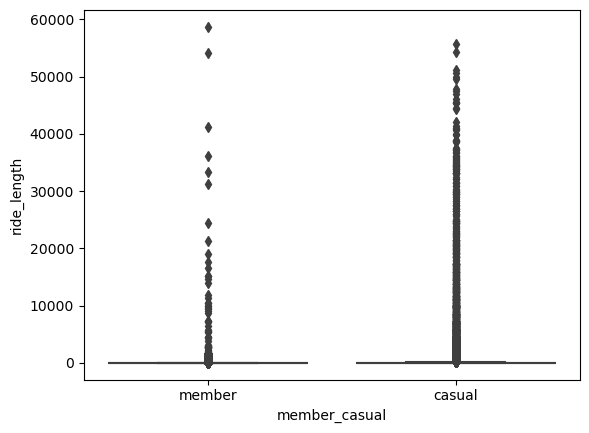

In [17]:
sns.boxplot(data=df, x='member_casual', y='ride_length', order=['member', 'casual'])

Some of the subscribed users and most of the casual users use bikes for long periods of time (returning the bikes after days)

In [18]:
df['ride_id'] = df['ride_id'].str.strip()

df[df['ride_id'].duplicated()]

,ride_id,rideable_type,started_at,ended_at,member_casual,ride_length


All the `ride_id`'s are unique values.

## Data Analysis

In [19]:
df = df.astype({'ride_id': 'string',
                'rideable_type': 'category',
                'member_casual': 'category'})

df['year'] = df['started_at'].dt.year

cat1 = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
cat2 = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

df['month'] = df['started_at'].dt.month_name()
df['month'] = df['month'].astype(pd.CategoricalDtype(categories=cat1, ordered=False))

df['week_day'] = df['started_at'].dt.day_name()
df['week_day'] = df['week_day'].astype(pd.CategoricalDtype(categories=cat2, ordered=False))

df['hour'] = df['started_at'].dt.hour

df = df.astype({'year':'int',
                'hour': 'int'})

df.head()

,ride_id,rideable_type,started_at,ended_at,member_casual,ride_length,year,month,week_day,hour
0,A847FADBBC638E45,docked_bike,2020-04-26 17:45:14,2020-04-26 18:12:03,member,26,2020,April,Sunday,17
1,5405B80E996FF60D,docked_bike,2020-04-17 17:08:54,2020-04-17 17:17:03,member,8,2020,April,Friday,17
2,5DD24A79A4E006F4,docked_bike,2020-04-01 17:54:13,2020-04-01 18:08:36,member,14,2020,April,Wednesday,17
3,2A59BBDF5CDBA725,docked_bike,2020-04-07 12:50:19,2020-04-07 13:02:31,member,12,2020,April,Tuesday,12
4,27AD306C119C6158,docked_bike,2020-04-18 10:22:59,2020-04-18 11:15:54,casual,52,2020,April,Saturday,10


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3429432 entries, 0 to 3429431
Data columns (total 10 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ride_id        string        
 1   rideable_type  category      
 2   started_at     datetime64[ns]
 3   ended_at       datetime64[ns]
 4   member_casual  category      
 5   ride_length    int32         
 6   year           int32         
 7   month          category      
 8   week_day       category      
 9   hour           int32         
dtypes: category(4), datetime64[ns](2), int32(3), string(1)
memory usage: 130.8 MB


## Exploratory Data Analysis

### Analysing the Difference in Number of Rides between Casual and Member Riders

#### Number of Rides by User Type

In [21]:
pd.pivot_table(df,
               index='member_casual',
               values='ride_id',
               aggfunc=['count'],
               margins=True,
               margins_name='Total Count')

,count
,ride_id
member_casual,
casual,1410173
member,2019259
Total Count,3429432


In [105]:
fig1 = df.groupby('member_casual', as_index=False).count()

px.bar(fig1, y = 'member_casual', x = 'ride_id',
        color = 'member_casual', 
        title='Count of Rides by User Type',
        height = 300,
        text = 'ride_id', 
        labels = {'ride_id': 'Number of Rides', 'member_casual': 'User Type'},
        hover_name = 'member_casual', hover_data = {'member_casual': False, 'month': False, 'ride_id': True}, 
        color_discrete_map = {'casual': '#FF934F', 'member': '#058ED9'})

#### Number of Rides by Month

In [67]:
df_pv1 = pd.pivot_table(df,
              index = ['year', 'month', 'member_casual'],
              values = 'ride_id',
              aggfunc = ['count'],
              margins = True,
              margins_name = 'Total Count')
df_pv1 = df_pv1.loc[(df_pv1 != 0).any(axis=1)]
df_pv1

count
                                     ride_id
year        month     member_casual         
2020        April     casual           23466
                      member           60292
            May       casual           86216
                      member          111615
            June      casual          153319
                      member          185249
            July      casual          266691
                      member          276654
            August    casual          284375
                      member          325065
            September casual          226835
                      member          295491
            October   casual          141922
                      member          237996
            November  casual           86730
                      member          168432
            December  casual           29665
                      member           99832
2021        January   casual           17842
                      member           77573
            February  casual            9964
                      member           38685
            March     casual           83148
                      member          142375
Total Count                          3429432

In [104]:
fig2 = df.groupby(['year', 'month', 'member_casual'], as_index=False).count()
fig2 = fig2[fig2['ride_id'] != 0]

fig = px.bar(fig2, x='month', y='ride_id',
        color='member_casual',
        title='Count of Rides by Month',
        labels={'ride_id': 'Number of Rides', 'month': 'Months (Apr 2020 - Mar 2021)', 'member_casual': 'User Type'},
        hover_name = 'member_casual', hover_data = {'member_casual': False, 'month': True, 'ride_id': True},
        color_discrete_map = {'casual': '#FF934F', 'member': '#058ED9'})
fig.update_traces(width=0.7)
fig.show()

* Its clear that users prefer riding bikes in summer season. The number of users fall during winter season.
* Number of casual riders increase during summer.

#### Number of Rides by Day of Week

In [107]:
pd.pivot_table(df,
               index=['week_day', 'member_casual'],
               values='ride_id',
               aggfunc=['count'],
               margins=True,
               margins_name='Total Count')

count
                           ride_id
week_day    member_casual         
Sunday      casual          259667
            member          260720
Monday      casual          149134
            member          263226
Tuesday     casual          143307
            member          279915
Wednesday   casual          156293
            member          300426
Thursday    casual          164217
            member          295923
Friday      casual          205877
            member          301624
Saturday    casual          331678
            member          317425
Total Count                3429432

In [126]:
fig3 = df.groupby(['week_day', 'member_casual'], as_index=False).count()

fig = px.bar(fig3, x='week_day', y='ride_id',
        color='member_casual',
        title='Count of Rides by Days of Week',
        barmode='group',
        labels={'ride_id': 'Number of Rides', 'week_day': 'Days of Week', 'member_casual': 'User Type'},
        hover_name = 'member_casual', hover_data = {'member_casual': False, 'week_day': True, 'ride_id': True},
        color_discrete_map = {'casual': '#FF934F', 'member': '#058ED9'})
fig.show()

* Users like to ride on Saturdays and Sundays.
* Casual rider number is more on Saturdays, and very close to member rider count on Sundays!
* Rest of the week shows similar trends.

#### Number of Rides per Hour

In [114]:
pd.pivot_table(df,
              index = ['hour', 'member_casual'],
              values = 'ride_id',
              aggfunc = ['count'],
              margins = True,
              margins_name = 'Total Count').head()

count
                   ride_id
hour member_casual        
0    casual          22235
     member          11903
1    casual          13884
     member           6687
2    casual           7613

In [123]:
fig4 = df.groupby(['hour', 'member_casual'], as_index=False).count()

fig = px.bar(fig4, x='hour', y='ride_id',
        color='member_casual',
        title='Number of Rides per Hour',
        barmode='group',
        labels={'ride_id': 'Number of Rides', 'hour': 'Hour', 'member_casual': 'User Type'},
        hover_name = 'member_casual', hover_data = {'member_casual': False, 'hour': True, 'ride_id': True},
        color_discrete_map = {'casual': '#FF934F', 'member': '#058ED9'})
fig.update_xaxes(dtick=1)
fig.show()

### Analyzing Difference in Average Ride Length Between Casual riders and Members.

#### Average Ride Length in 1 Year

In [131]:
pd.pivot_table(df,
               index='member_casual',
               values='ride_length',
               aggfunc=['mean'],
               margins=True,
               margins_name='Average Ride Length')

,mean
,ride_length
member_casual,
casual,45.014347
member,15.879930
Average Ride Length,27.859922


In [148]:
fig5 = round(df.groupby('member_casual', as_index=False)['ride_length'].mean(), 2)

fig = px.bar(fig5, y='member_casual', x='ride_length', 
        color='member_casual', 
        height=300,
        title='Average Ride Length by User Type',
        text='ride_length', 
        labels={'ride_length': 'Average Ride Length (minutes)', 'member_casual': 'User Type'},
        hover_name='member_casual', hover_data = {'member_casual': False, 'ride_length': True}, 
        color_discrete_map={'casual': '#FF934F', 'member': '#058ED9'})

fig.show()

The average ride length of casual riders are more than twice of members!

#### Average Ride Length in Each Month

In [132]:
pd.pivot_table(df,
               index=['year', 'month', 'member_casual'],
               values=['ride_length'],
               aggfunc=['mean'],
               margins=True,
               margins_name='Average Ride Length')

mean
                                            ride_length
year                month     member_casual            
2020                April     casual          73.078923
                              member          21.275194
                    May       casual          51.097580
                              member          19.566546
                    June      casual          51.587448
                              member          18.512931
                    July      casual          59.903829
                              member          17.549911
                    August    casual          45.108687
                              member          16.640198
                    September casual          38.268014
                              member          15.319813
                    October   casual          30.314469
                              member          13.800984
                    November  casual          31.756532
                              member          13.294522
                    December  casual          26.653733
                              member          12.421138
2021                January   casual          25.582222
                              member          12.565016
                    February  casual          49.699117
                              member          17.898255
                    March     casual          38.069527
                              member          13.677619
Average Ride Length                           27.859922

In [149]:
fig6 = round(df.groupby(['year', 'month', 'member_casual'], as_index=False)['ride_length'].mean(), 1).dropna(ignore_index=True)

fig = px.bar(fig6, x='month', y='ride_length',
        color='member_casual',
        text='ride_length', 
        title='Average Ride Length by Months',
        labels={'ride_length': 'Average Ride Length (minutes)', 'member_casual': 'User Type', 'month': 'Months (Apr 2020 - Mar 2021)'},
        hover_name='member_casual', hover_data={'member_casual': False, 'ride_length': True}, 
        color_discrete_map={'casual': '#FF934F', 'member': '#058ED9'})

fig.show()

* Average ride length of casual riders is more than twice than members in all months.
* Its seen that Average ride length of February 2021 is unusually higher than the adjacent months. As reported in News earlier, (You can read news [here](https://www.nbcchicago.com/news/local/nws-chicago-had-9th-snowiest-february-on-record-with-nearly-2-feet-of-snow/2450777/)) Chicago had 9th Snowiest February on Record and snowstorm in 2021.
* It seems that riders were not able to return bikes as usual and bikes were stuck with them in the month of February. This increased the ride length. In the graph of "Number of Rides by Month", we can see that February has the lowest number of rides in all months.

#### Average Ride Length by Days of Week

In [150]:
pd.pivot_table(df,
               index=['week_day', 'member_casual'],
               values=['ride_length'],
               aggfunc=['mean'],
               margins=True,
               margins_name='Average Ride Length')

mean
                                  ride_length
week_day            member_casual            
Sunday              casual          50.756877
                    member          18.039805
Monday              casual          45.094271
                    member          15.079844
Tuesday             casual          40.545396
                    member          14.873805
Wednesday           casual          40.361552
                    member          15.057019
Thursday            casual          43.043631
                    member          14.945307
Friday              casual          42.827518
                    member          15.555108
Saturday            casual          46.939134
                    member          17.615412
Average Ride Length                 27.859922

In [155]:
fig7 = round(df.groupby(['week_day', 'member_casual'], as_index=False)['ride_length'].mean(), 2)

fig = px.bar(fig7, x='week_day', y='ride_length',
        color='member_casual',
        text='ride_length', 
        title='Average Ride Length by Days of Week',
        labels={'ride_length': 'Average Ride Length (minutes)', 'member_casual': 'User Type', 'week_day': 'Week Days'},
        hover_name='member_casual', hover_data={'member_casual': False, 'ride_length': True}, 
        color_discrete_map={'casual': '#FF934F', 'member': '#058ED9'})

fig.show()

* In Weekends casual riders' ride length is maximum when compared to weekdays.
* Members' ride length tend to be almost same in all weekdays and marginally higher in weekends.
* Both casual riders and members use bikes for long rides during weekends.

### Analyzing Difference in Rideable Type Usage Between Casual riders and Members.

#### Count of Bike Types used in the Month

In [191]:
fig9 = df.groupby(['year', 'month', 'rideable_type'], as_index=False)['ride_id'].count()
fig9 = fig9[fig9['ride_id'] != 0]
fig9

,year,month,rideable_type,ride_id
10,2020,April,docked_bike,83758
13,2020,May,docked_bike,197831
16,2020,June,docked_bike,338568
19,2020,July,docked_bike,541569
20,2020,July,electric_bike,1776
22,2020,August,docked_bike,546106
23,2020,August,electric_bike,63334
25,2020,September,docked_bike,396882
26,2020,September,electric_bike,125444
28,2020,October,docked_bike,231167


In [195]:
fig = px.bar(fig9, x='month', y='ride_id',
        color='rideable_type',
        title='Number of Rides by Bike Types in Each Month',
        labels={'ride_id': 'Number of Rides', 'rideable_type': 'Bike Type', 'month': 'Months (Apr 2020 - Mar 2021)'},
        hover_name='rideable_type', hover_data={'ride_id': True, 'month': False}, 
        color_discrete_map={'casual': '#FF934F', 'member': '#058ED9'})

fig.show()

* Docked bikes were the only available bikes in the beginning. Then Electric bike was introduced around in August and Classic bikes around in December.
* Electric and Classic bikes have gained popularity among users.

#### Count of User Type by Bike Types Used for Riding

In [157]:
pd.pivot_table(data=df,
               index=['rideable_type', 'member_casual'],
               values='ride_id',
               aggfunc=['count'],
               margins=True,
               margins_name='Total Count')

count
                             ride_id
rideable_type member_casual         
classic_bike  casual           70197
              member          245911
docked_bike   casual         1104212
              member         1411963
electric_bike casual          235764
              member          361385
Total Count                  3429432

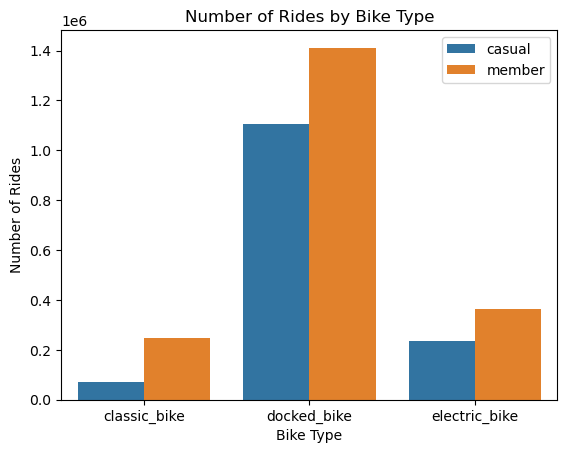

In [166]:
fig8 = df.groupby(['rideable_type', 'member_casual'], as_index=False)['ride_id'].count()

sns.barplot(data=fig8, x='rideable_type', y='ride_id', hue='member_casual')
plt.xlabel('Bike Type')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Bike Type')
plt.legend(loc='upper right')
plt.show()

## Conclusions

* Annual members and Casual riders use Cyclistic bike share differently.
* The average ride length of causual riders are more than twice as of members.
* From the average ride length difference, we can conclude that Annual members usually use bike share for daily commuting, while casual riders mostly use bike share for leisure rides mostly during Weekends.
* But there are a fixed number of casual riders who use bike share for commuting.

## Recommendations

* A new Annual Membership package for Weekend usage only will attract current Weekend casual riders.
* Promotions aiming at current Weekday casual riders must be implemented as soon as possible. Those promotions must provide some kind of an incentive when compared to single passes and full day passes for a year long period.
* A Loyalty Program for casual riders can be implemented, where occasional membership fees discounts must be given to casual riders with high loyalty points.

***